In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from models import SimpleConv, AlexNetLike, ResNet18

from einops import rearrange, reduce, repeat
from utils.timer import Timer
from utils.utility import generate_data_folders

# %matplotlib inline

In [2]:
device = 'cuda'

print(os.getcwd())
path_data_base = '../data/'
path_images = os.path.join(path_data_base, 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset')
path_img_train = os.path.join(path_images, 'train')
path_img_val = os.path.join(path_images, 'val')
path_img_test = os.path.join(path_images, 'test')

/home/bozidar/repos/pneumonia-xray/code


In [3]:
meta = pd.read_csv(os.path.join(path_data_base, 'Chest_xray_Corona_Metadata.csv'))
meta.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [4]:
train = meta[meta['Dataset_type'] == 'TRAIN'].copy().reset_index(drop=True)
test = meta[meta['Dataset_type'] == 'TEST'].copy().reset_index(drop=True)
n_train = len(train)
n_test = len(test)

train_name = train['X_ray_image_name']
train_label = train['Label']
test_name = test['X_ray_image_name']
test_label = test['Label']

print(f'{n_train=} {n_test=}')

n_train=5286 n_test=624


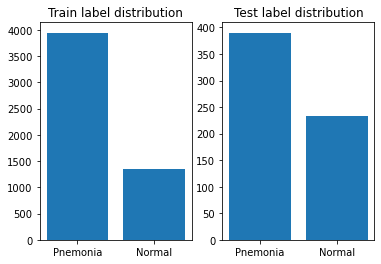

In [5]:
train_counts = train_label.value_counts()
test_counts = test_label.value_counts()

fig, ax = plt.subplots(1, 2)
ax[0].bar(train_counts.keys(), train_counts.values)
ax[1].bar(test_counts.keys(), test_counts.values)
ax[0].set_title('Train label distribution')
ax[1].set_title('Test label distribution')
fig.show()

In [6]:
# generate folder structure to use torchvision imageloader
# DON'T RUN EVERY TIME
# generate_data_folders(path_images, 'train', train_name, train_label, split=0.1)
# generate_data_folders(path_images, 'test', test_name, test_label)

In [7]:
img_h, img_w = 224, 224

inspect_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((img_h, img_w)),
                                                   torchvision.transforms.ToTensor()])
inspect_data = torchvision.datasets.ImageFolder(path_img_train, transform=inspect_transform)
inspect_loader = DataLoader(inspect_data, batch_size=1, shuffle=True)

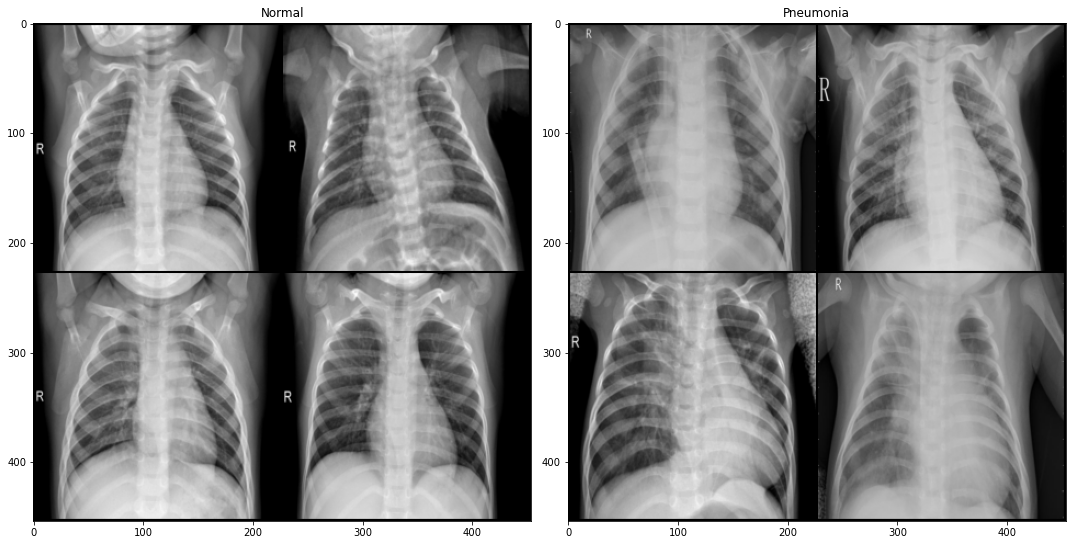

In [8]:
num = 4 # set even
cnt = [0, 0]
norm, pneum = [], [] 

for img, lbl in inspect_loader:
    if lbl == 1 and cnt[lbl] < num:
        pneum.append(img)
        cnt[lbl] += 1
    elif lbl == 0 and cnt[lbl] < num:
        norm.append(img)
        cnt[lbl] += 1
    elif cnt[0]+cnt[1] == 2*num:
        break
    
norm = torch.cat(norm, axis=0)
pneum = torch.cat(pneum, axis=0)
grid_norm = torchvision.utils.make_grid(norm, nrow=2)
grid_pneum = torchvision.utils.make_grid(pneum, nrow=2)

fig, ax = plt.subplots(1, 2, figsize=(15,30))
ax[0].imshow(rearrange(grid_norm, 'c h w -> h w c'))
ax[0].set_title('Normal')
ax[1].imshow(rearrange(grid_pneum, 'c h w -> h w c'))
ax[1].set_title('Pneumonia')
fig.show()
fig.tight_layout()

In [9]:
# only once to calculate values for normalization
# imgs = []
# inspect_loader = DataLoader(inspect_data, batch_size=128, shuffle=True)
# for img, _ in inspect_loader:
#     imgs.append(img)
#     i += 1
# ti = torch.cat(imgs, axis=0)

# means = torch.mean(ti, dim=(0,2,3))
# stds = torch.std(ti, dim=(0,2,3))
# print(f'{means=} {stds=}')

In [10]:
# img_h, img_w = 224, 224
img_h, img_w = 224, 224
batch_size = 128

train_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((img_h, img_w)),
                                                  torchvision.transforms.RandomHorizontalFlip(p=0.5),
                                                  torchvision.transforms.RandomVerticalFlip(p=0.1),
                                                  torchvision.transforms.RandomRotation(15),
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(mean=[0.4828, 0.4829, 0.4829], std=[0.2361, 0.2361, 0.2361])
                                                   ])

val_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((img_h, img_w)),
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(mean=[0.4828, 0.4829, 0.4829], std=[0.2361, 0.2361, 0.2361])
                                                   ])

test_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((img_h, img_w)),
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(mean=[0.4828, 0.4829, 0.4829], std=[0.2361, 0.2361, 0.2361])
                                                   ])

train_data = torchvision.datasets.ImageFolder(path_img_train, transform=train_transform)
val_data = torchvision.datasets.ImageFolder(path_img_val, transform=val_transform)
test_data = torchvision.datasets.ImageFolder(path_img_test, transform=test_transform)

In [11]:
model = SimpleConv(size_in=torch.Size((img_h, img_w)), size_out=2, activation='relu')
# model = AlexNetLike(size_in=torch.Size((img_h, img_w)), size_out=2)
# model = ResNet18(size_in=torch.Size((img_h, img_w)), size_out=2)

In [12]:
model.train(train_data, val_data, n_epochs=1, tensor_board=True, exp_name='simple_conv1')

  0%|          | 0/5 [00:00<?, ?it/s]
[TRAIN]Epoch 0 Loss: 0.611192790237633 Acc: 0.710879921913147
100%|██████████| 5/5 [00:09<00:00,  1.90s/it]
[VAL]Epoch 0 Loss: 0.5782992482185364 Acc: 0.743526816368103

Elapsed time: 0:01:41
Training finished!



In [13]:
model.test(test_data)

100%|██████████| 5/5 [00:09<00:00,  1.90s/it]
[TEST] Loss: 0.68969566822052 Acc: 0.6243304014205933



In [14]:
# model.save_model('models/simple_conv_e2')

Model saved to models/simple_conv_e2


In [16]:
# mod = SimpleConv(size_in=torch.Size((img_h, img_w)), size_out=2)
# mod.load_model('models/simple_conv_e2')
# mod.test(test_data)

100%|██████████| 5/5 [00:09<00:00,  1.90s/it]
[TEST] Loss: 0.6888183236122132 Acc: 0.625



In [17]:
# mod.predict(test_data, batch_size=batch_size)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
# TODO: confusion matrix, maybe change (stratify) validation set